In [ ]:
# importing packages and tools to be used
# datframe and array lib
import numpy as np
import pandas as pd

# Data visualization
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn import model_selection
from sklearn.impute import SimpleImputer
from sklearn.model_selection import train_test_split, cross_val_score, KFold, learning_curve, StratifiedKFold, train_test_split
from sklearn.tree import DecisionTreeClassifier
from sklearn.svm import SVC
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier, AdaBoostClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.metrics import classification_report
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense
from sklearn.preprocessing import StandardScaler
from tensorflow.keras.layers import Dropout
from imblearn.over_sampling import RandomOverSampler
from sklearn.utils.class_weight import compute_class_weight

from sklearn.model_selection import cross_val_score
import warnings
warnings.filterwarnings("ignore")
%matplotlib inline
from sklearn.metrics import classification_report, accuracy_score, confusion_matrix, roc_curve


Dataset Preparation
*  Feature -
*   Labels -


In [2]:
df = pd.read_csv('diabetes.csv')
df.head(10)

,Pregnancies,Glucose,BloodPressure,SkinThickness,Insulin,BMI,DiabetesPedigreeFunction,Age,Outcome
0,6,148,72,35,0,33.6,0.627,50,1
1,1,85,66,29,0,26.6,0.351,31,0
2,8,183,64,0,0,23.3,0.672,32,1
3,1,89,66,23,94,28.1,0.167,21,0
4,0,137,40,35,168,43.1,2.288,33,1
5,5,116,74,0,0,25.6,0.201,30,0
6,3,78,50,32,88,31.0,0.248,26,1
7,10,115,0,0,0,35.3,0.134,29,0
8,2,197,70,45,543,30.5,0.158,53,1
9,8,125,96,0,0,0.0,0.232,54,1


Dataset Exploration/Visualization



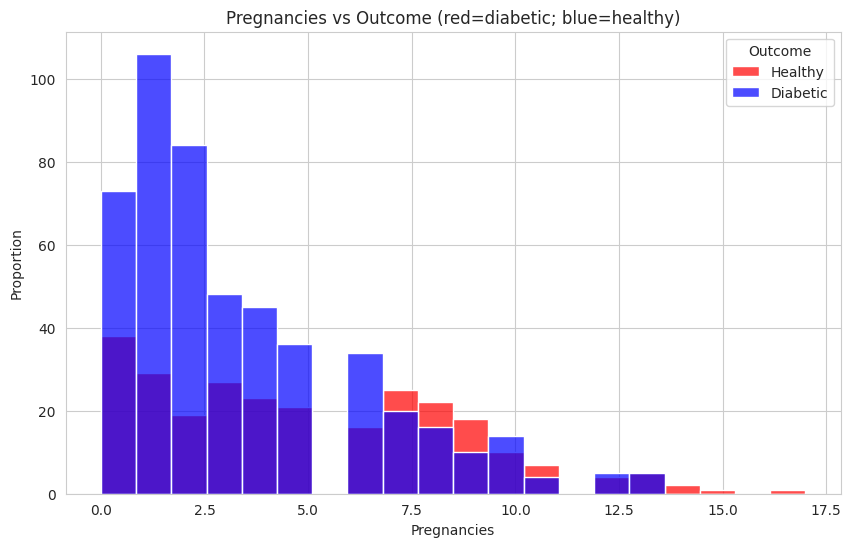

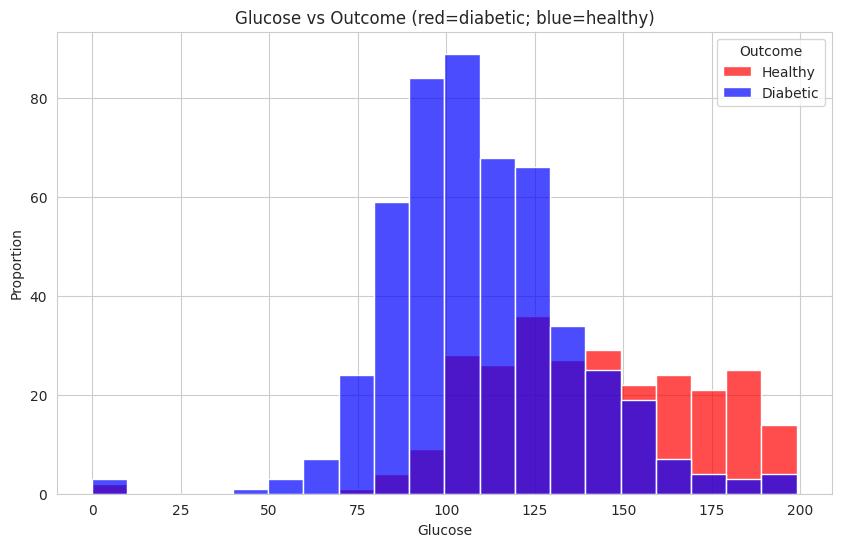

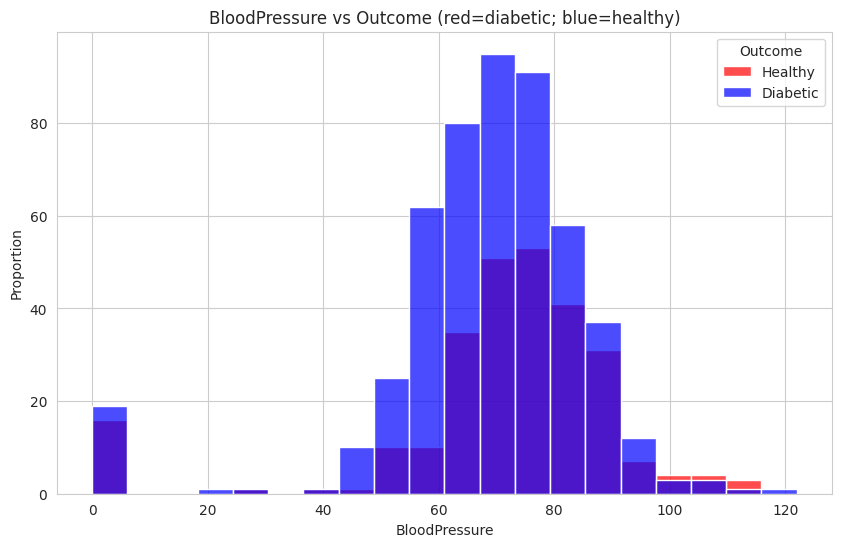

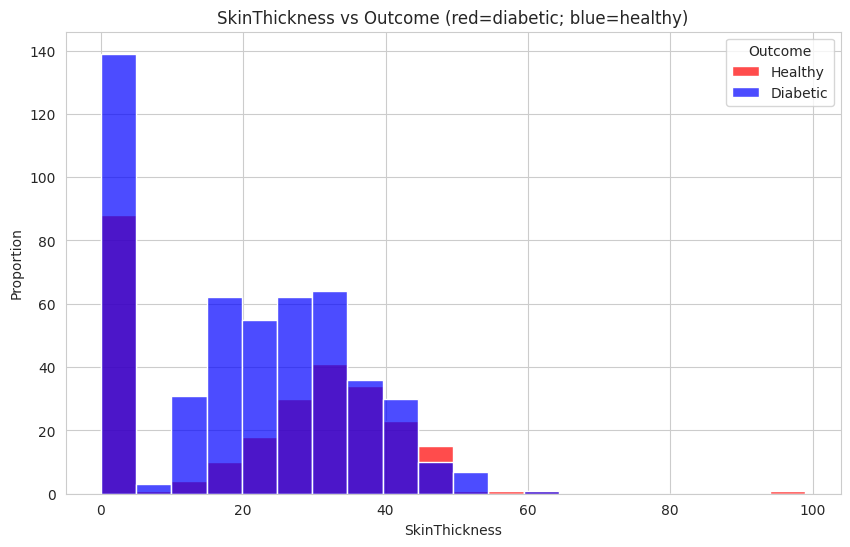

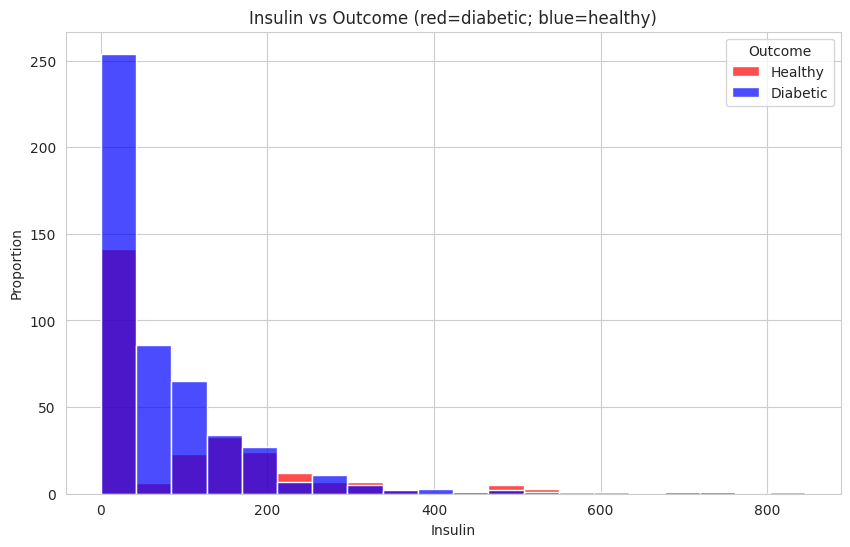

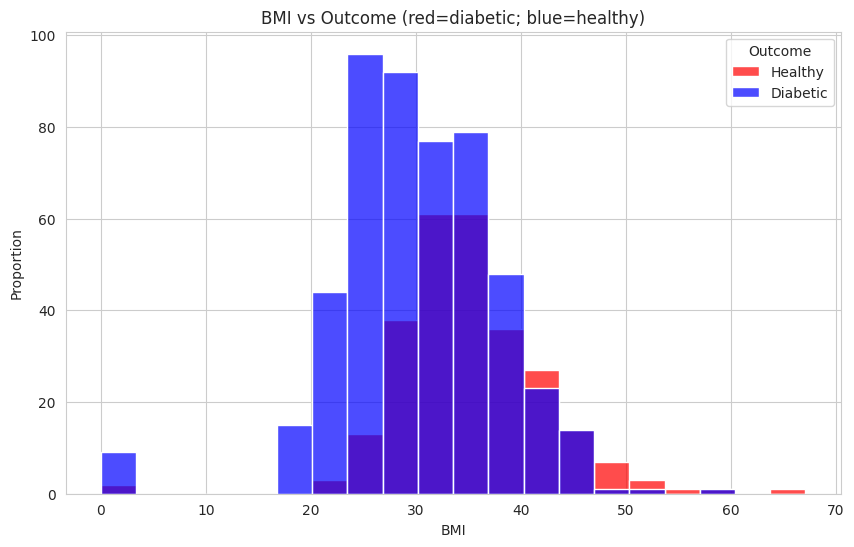

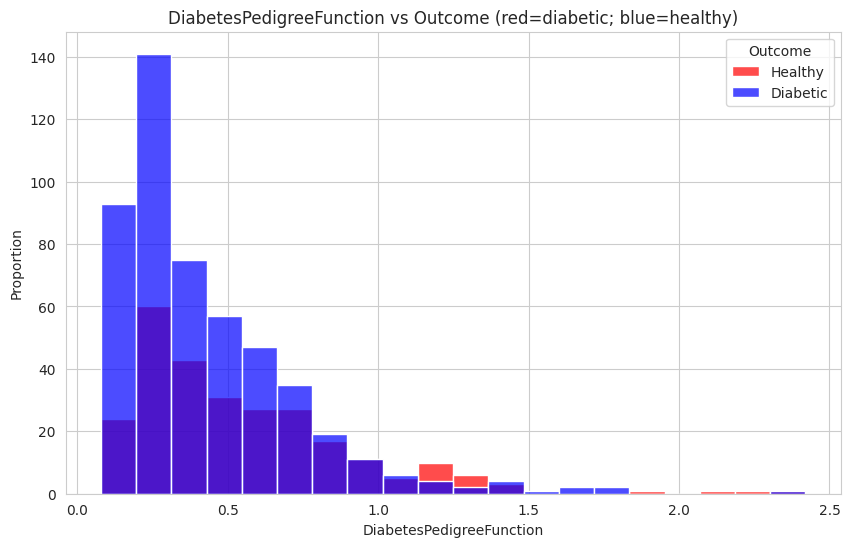

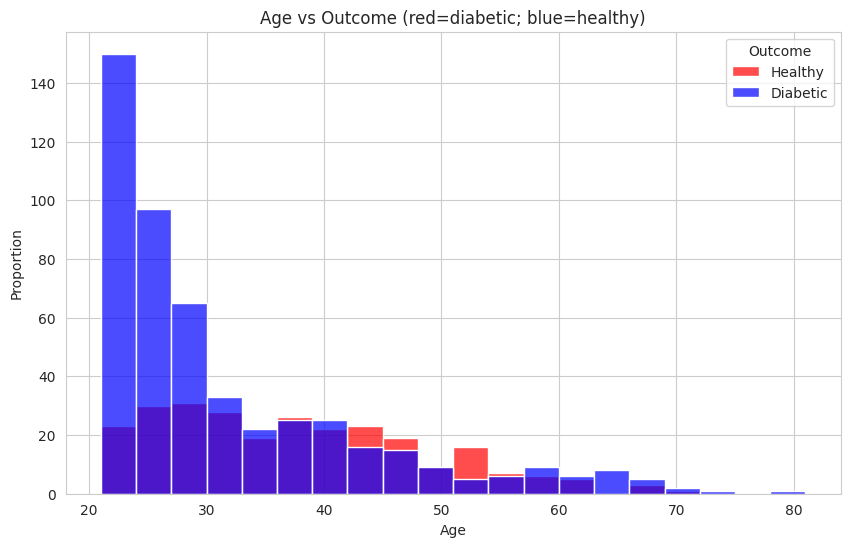

In [3]:
# lets visualize the feature against the label, esp the insulin and skinthickness
# to determine if there is correlation between a particular outcome and the nulled insulin and skintype
# Loop through each feature except the label (Outcome)
for feature in df.columns[:-1]:
    def plotHistogram(values, label, feature, title):
        sns.set_style("whitegrid")

        # Define a custom palette for the outcomes
        custom_palette = {0: "blue", 1: "red"}

        # Use sns.histplot
        plt.figure(figsize=(10, 6))
        sns.histplot(
            data=values,
            x=feature,
            hue=label,
            kde=False,
            palette=custom_palette,
            bins=20,
            alpha=0.7
        )
        plt.title(title)
        plt.xlabel(feature)
        plt.ylabel('Proportion')
        plt.legend(labels=["Healthy", "Diabetic"], title=label)
        plt.show()

    # Call the function
    plotHistogram(
        df,
        df.columns[-1],
        feature,
        f"{feature} vs {df.columns[-1]} (red=diabetic; blue=healthy)"
    )


so i can genearalize that the absence of
insulin doesnt necesarry correlate to diabetic thus our model wouldnt be biased

---

Later we will closly observe this plot to understand the relationship between outcomes and the feature ot develop a simple recommendation algorithm

# Data Preprocessing
Working with missing values

In [4]:
df[df.columns[:-1]] = df[df.columns[:-1]].replace(0, np.nan)

In [5]:
check_shape = df.drop(['Outcome'], axis=1)
print(f'\n The shape is - {check_shape.shape}')


 The shape is - (768, 8)


In [6]:
print("Nulls \t\t\t   % of nulls \n")
print(df.isnull().sum()/768*100)

Nulls 			   % of nulls 

Pregnancies                 14.453125
Glucose                      0.651042
BloodPressure                4.557292
SkinThickness               29.557292
Insulin                     48.697917
BMI                          1.432292
DiabetesPedigreeFunction     0.000000
Age                          0.000000
Outcome                      0.000000
dtype: float64


FEATURE ENGINEERING/SELECTION


---

At this point i am going to split the datset to training and testing. After this i will apply the median imuter because of the outlier and skewed nature to fill up the null value..

---

i will now use the imputer to fir(learn) and transform the xtrain..then apply this value to the xtest to prevemt data leakage or overfitting re-learning

---

Also this imputation is not applied before splitting so our model would'nt learn bad data..we'll be test on our real-based datset and also prevemt overly optimistc metrics

In [7]:
train, valid, test = np.split(df.sample(frac=1), [int(0.6*len(df)), int(0.8*len(df))])

In [8]:
# Initialize imputer and scaler globally or once in the training pipeline
imputer = SimpleImputer(missing_values=np.nan,strategy='median')
scaler = StandardScaler()

In [9]:
# Define the function
def label_features(dataframe, fitTransform=True, oversample=True):
    X = dataframe[dataframe.columns[:-1]]  # All columns except the last one
    y = dataframe[dataframe.columns[-1]]   # The last column

    if fitTransform:
        X_imputed = imputer.fit_transform(X)
        X_scaled = scaler.fit_transform(X_imputed)
    else:
        X_imputed = imputer.transform(X)
        X_scaled = scaler.transform(X_imputed)

    if oversample:
        ros = RandomOverSampler(random_state=42)
        X_scaled, y = ros.fit_resample(X_scaled, y)

    return X_scaled, y


In [10]:
X_train_scaled, y_train = label_features(train, fitTransform=True, oversample=True)
X_valid_scaled, y_valid = label_features(valid, fitTransform=False, oversample=False)
X_test_scaled, y_test = label_features(test, fitTransform=False, oversample=False)


In [11]:
# lets confirm there isnt null
x_train2 = pd.DataFrame(X_train_scaled)
x_test2 = pd.DataFrame(X_test_scaled)

print(f"Confirm X_train_imputed \n{x_train2.isnull().sum()}")
print(f"\nConfirm X_test_imputed \n{x_test2.isnull().sum()}")

Confirm X_train_imputed 
0    0
1    0
2    0
3    0
4    0
5    0
6    0
7    0
dtype: int64

Confirm X_test_imputed 
0    0
1    0
2    0
3    0
4    0
5    0
6    0
7    0
dtype: int64


In [12]:
# Models to test with hyperparameters
models = {
    "Decision Tree": DecisionTreeClassifier(random_state=1, max_depth=5, min_samples_split=10, min_samples_leaf=5),
    "SVM": SVC(random_state=1, kernel='rbf', C=1, gamma='scale'),
    "Logistic Regression": LogisticRegression(random_state=1, C=1.0, solver='liblinear'),
    "Random Forest Classifier": RandomForestClassifier(random_state=1, n_estimators=100, max_depth=10, min_samples_split=10),
    "K-Nearest Neighbors": KNeighborsClassifier(n_neighbors=5, weights='uniform', algorithm='auto'),
    "Gradient Boosting": GradientBoostingClassifier(random_state=1, n_estimators=100, learning_rate=0.1, max_depth=3),
    "Naive Bayes": GaussianNB()
}

# Train and evaluate each model
for model_name, model in models.items():
    print(f"Training {model_name}...")
    # Train for Medicine prediction
    model.fit(X_train_scaled, y_train)
    y_pred = model.predict(X_test_scaled)
    print(f"{model_name} Model Performance:")
    print(classification_report(y_test, y_pred))

Training Decision Tree...
Decision Tree Model Performance:
              precision    recall  f1-score   support

           0       0.82      0.82      0.82       103
           1       0.63      0.65      0.64        51

    accuracy                           0.76       154
   macro avg       0.73      0.73      0.73       154
weighted avg       0.76      0.76      0.76       154

Training SVM...
SVM Model Performance:
              precision    recall  f1-score   support

           0       0.81      0.78      0.79       103
           1       0.58      0.63      0.60        51

    accuracy                           0.73       154
   macro avg       0.69      0.70      0.70       154
weighted avg       0.73      0.73      0.73       154

Training Logistic Regression...
Logistic Regression Model Performance:
              precision    recall  f1-score   support

           0       0.84      0.79      0.81       103
           1       0.62      0.71      0.66        51

    accuracy 

In [13]:
# Build a more complex model with dropout
def create_improved_nn_model():
    model = Sequential()
    model.add(Dense(units=128, activation='relu', input_dim=X_train_scaled.shape[1]))  # Increased units in the first layer
    model.add(Dropout(0.2))  # Dropout for regularization
    model.add(Dense(units=64, activation='relu'))  # Second hidden layer with more units
    model.add(Dropout(0.2))  # Dropout for regularization
    model.add(Dense(units=32, activation='relu'))  # Third hidden layer
    model.add(Dense(units=1, activation='sigmoid'))  # Output layer

    # Compile the model with a tuned learning rate
    model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=0.001),
                  loss='binary_crossentropy',
                  metrics=['accuracy'])
    return model

In [14]:
# Train the improved model
improved_nn_model = create_improved_nn_model()
improved_nn_model.fit(X_train_scaled, y_train, epochs=20, batch_size=32, verbose=1)  # Increased epochs


Epoch 1/20
19/19 ━━━━━━━━━━━━━━━━━━━━ 5s 5ms/step - accuracy: 0.5792 - loss: 0.6703
Epoch 2/20
19/19 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.7388 - loss: 0.5446
Epoch 3/20
19/19 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.7813 - loss: 0.4902
Epoch 4/20
19/19 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - accuracy: 0.7787 - loss: 0.4797
Epoch 5/20
19/19 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.8095 - loss: 0.4470
Epoch 6/20
19/19 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - accuracy: 0.7857 - loss: 0.4490
Epoch 7/20
19/19 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.7991 - loss: 0.4450
Epoch 8/20
19/19 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.8036 - loss: 0.4224 
Epoch 9/20
19/19 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.8346 - loss: 0.4241 
Epoch 10/20
19/19 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.7855 - loss: 0.4584  
Epoch 11/20
19/19 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.7948 - loss: 0.4271 
Epoch 12/20
19/19 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.8130

In [15]:
# Make predictions
y_pred_improved_nn = (improved_nn_model.predict(X_test_scaled) > 0.5).astype("int32")


5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step


In [16]:
# Evaluate performance
print("Improved Neural Network Model Performance:")
print(classification_report(y_test, y_pred_improved_nn))

Improved Neural Network Model Performance:
              precision    recall  f1-score   support

           0       0.86      0.77      0.81       103
           1       0.61      0.75      0.67        51

    accuracy                           0.76       154
   macro avg       0.74      0.76      0.74       154
weighted avg       0.78      0.76      0.76       154



In [17]:
# Function to define and compile the model
def train_model(X_train_scaled, y_train, num_nodes, dropout, lr, batchsize, epochs):
    nn_model = tf.keras.Sequential([
        tf.keras.layers.Dense(num_nodes, activation='relu', input_shape=(X_train_scaled.shape[1],)),
        tf.keras.layers.Dropout(dropout),
        tf.keras.layers.Dense(num_nodes, activation='relu'),
        tf.keras.layers.Dropout(dropout),
        tf.keras.layers.Dense(1, activation='sigmoid')
    ])

    nn_model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=lr),
                     loss='binary_crossentropy',
                     metrics=['accuracy'])

    return nn_model

In [21]:
from sklearn.utils.class_weight import compute_class_weight

# Compute class weights
class_weights = compute_class_weight('balanced', classes=np.array([0, 1]), y=y_train)
# Initialize results
results = []

# Training loop with logging
for num_nodes in [16, 32, 64]:
    for dropout_prob in [0.1, 0.3, 0.5]:
        for lr in [0.01, 0.005, 0.001]:
            for batch_size in [32, 64]:
                print(f"Training: nodes={num_nodes}, dropout={dropout_prob}, lr={lr}, batch_size={batch_size}")
                model = train_model(X_train_scaled, y_train, num_nodes, dropout_prob, lr, batch_size, epochs)

                # Early stopping and learning rate scheduler
                early_stopping = tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True)
                lr_scheduler = tf.keras.callbacks.ReduceLROnPlateau(monitor='val_loss', factor=0.5, patience=5)

                # Train the model
                history = model.fit(
                    X_train_scaled, y_train,
                    validation_data=(X_valid_scaled, y_valid),
                    batch_size=batch_size,
                    epochs=epochs,
                    class_weight=dict(enumerate(class_weights)),
                    callbacks=[early_stopping, lr_scheduler],
                    verbose=0
                )

                # Evaluate on test data
                val_loss, val_accuracy = model.evaluate(X_test_scaled, y_test, verbose=0)
                results.append({'num_nodes': num_nodes, 'dropout': dropout_prob, 'lr': lr,
                                'batch_size': batch_size, 'val_loss': val_loss, 'val_accuracy': val_accuracy})


Training: nodes=16, dropout=0.1, lr=0.01, batch_size=32
Training: nodes=16, dropout=0.1, lr=0.01, batch_size=64
Training: nodes=16, dropout=0.1, lr=0.005, batch_size=32
Training: nodes=16, dropout=0.1, lr=0.005, batch_size=64
Training: nodes=16, dropout=0.1, lr=0.001, batch_size=32
Training: nodes=16, dropout=0.1, lr=0.001, batch_size=64
Training: nodes=16, dropout=0.3, lr=0.01, batch_size=32
Training: nodes=16, dropout=0.3, lr=0.01, batch_size=64
Training: nodes=16, dropout=0.3, lr=0.005, batch_size=32
Training: nodes=16, dropout=0.3, lr=0.005, batch_size=64
Training: nodes=16, dropout=0.3, lr=0.001, batch_size=32
Training: nodes=16, dropout=0.3, lr=0.001, batch_size=64
Training: nodes=16, dropout=0.5, lr=0.01, batch_size=32
Training: nodes=16, dropout=0.5, lr=0.01, batch_size=64
Training: nodes=16, dropout=0.5, lr=0.005, batch_size=32
Training: nodes=16, dropout=0.5, lr=0.005, batch_size=64
Training: nodes=16, dropout=0.5, lr=0.001, batch_size=32
Training: nodes=16, dropout=0.5, lr=0

In [22]:
# Sort results by validation loss
best_config = sorted(results, key=lambda x: x['val_loss'])[0]
print("Best Configuration:", best_config)


Best Configuration: {'num_nodes': 16, 'dropout': 0.1, 'lr': 0.001, 'batch_size': 64, 'val_loss': 0.4569237530231476, 'val_accuracy': 0.7662337422370911}


In [23]:
y_pred = least_val_model.predict(X_test_scaled)
y_pred = (y_pred > 0.5).astype(int).reshape(-1,)# due to itz sigmoid nature it is values close to 0 or 1 , so
# we change that to true or false with itz equivalents in 0 and 1, and reshzpe to 1d

5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step


In [24]:
# Evaluate performance
print("Improved Neural Network Model Performance with tunings:")
print(classification_report(y_test, y_pred))

Improved Neural Network Model Performance with tunings:
              precision    recall  f1-score   support

           0       0.85      0.78      0.81       103
           1       0.62      0.73      0.67        51

    accuracy                           0.76       154
   macro avg       0.73      0.75      0.74       154
weighted avg       0.77      0.76      0.76       154

